## Imports necessary for the code to work

In [1]:
import pandas as pd
from scipy.ndimage.filters import generic_filter
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import warnings

def get_lethality_rate(data: pd.DataFrame,
                       country: str, *,
                       smoothing_size=7,
                       additional_plots=[],
                       death_delay=1,
                       height=2,
                       start=None,
                       end=None,
                       ylim=None):
    """
    Plot a figure with including the lethatlity rate and
    some other plots if asked to.
    It is a fairly simple function but should allow you to
    do few things that could be useful.
    The lethality of a given day `d` is computed as the number
    of positive persons during `max(1, death_delay)` days divided
    by the number of death during `max(1, death_delay)` days,
    `death_delay` days after the day `d`.
    
    Args:
    ----
        country (str): The name of the country to plot
        smoothing_size (int): the size of the smoothing in days
            default value: 7, meaning that each value is the
            average value over 7 days
        additional_plot (list of str): List of values to plot.
            The available values can be accessed by doing
            `data.keys()`.
            Default value: [] (no other plot is made)
        death_delay (int): The delay in days to compute the
            lethality ratio
        height (int): the height of 1 plot (given than the width is 10).
        start (str): starting date from which to make the plot.
            The date is expected to be in the format 'yyyy-mm-dd'.
            If None is given starts at the begining of the dataset.
            Default None
        end (str): ending date to which to make the plot.
            The date is expected to be in the format 'yyyy-mm-dd'.
            If None is given ends at the end of the dataset.
            Default `None`
        ylim (2-tuple): min and max value for the lethality ratio
    """
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    if ylim is None:
        ylim = (0, 0.04)
    country_data = data[data['location']==country]
    if start is None:
        start = country_data['date'].min()
    if end is None:
        end = country_data['date'].max()
    to_keep = (start<=country_data['date'])&(country_data['date']<=end)
    sub_data = country_data[to_keep] 
    dates = sub_data['date'][to_keep]
    months = np.array([date.fromisoformat(d).strftime('%b-%Y') for d in dates])
    all_ticks = np.arange(len(months))
    ticks = np.where(months[1:]!=months[:-1])[0]
    tick_labels = months[ticks+1]
    nb_plots = 1+len(additional_plots)
    fig, axes = plt.subplots(nb_plots, 1, figsize=(10, height*nb_plots), sharex=True)
    if 1 < nb_plots:
        ax = axes[0]
    else:
        ax = axes

    cases = generic_filter(country_data.sort_values('date')['new_cases'],
                           np.nanmean, size=smoothing_size)
    death = generic_filter(country_data.sort_values('date')['new_deaths'],
                           np.nanmean, size=smoothing_size)
    if death_delay == 0:
        lethality_rate = death/cases
    else:
        lethality_rate = death[death_delay:]/cases[:-death_delay]
    lethality_rate[1<lethality_rate]=0
    lethality_rate = lethality_rate[to_keep[death_delay:]]
    all_ticks = all_ticks[len(all_ticks)-len(lethality_rate):]
    ax.plot(all_ticks, lethality_rate, '-', label='Lethality ratio')
    ax.set_ylabel('Ratio death over #cases')
    ax.set_ylim(ylim)
    ax.legend()
    ax.set_title(country)
    if 1 < nb_plots:
        for ax, val in zip(axes[1:], additional_plots):
            Y = generic_filter(country_data.sort_values('date')[val],
                               np.nanmean, size=smoothing_size)[to_keep]
            ax.plot(Y, '-', label=val)
            ax.set_ylabel(f'#{val}')
            if 'per_hundred' in val:
                ax.set_ylim(0, 100)
            ax.legend()
    step_ticks = max(1, len(ticks)//6)
    ax.set_xticks(ticks[::step_ticks])
    ax.set_xticklabels(tick_labels[::step_ticks])
    fig.tight_layout()
    return fig

## Loading the dateset
The dataset is loaded from [Our World in Data](https://ourworldindata.org/) [covid-19-data repository](https://github.com/owid/covid-19-data/).

In [2]:
data_path = 'https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv'
data = pd.read_csv(data_path)
countries = data['location'].unique()

## Plotting examples

The function `get_lethality_rate` allows us to plot our dataset.

By default, this function plots some measurements of the lethality rate.
Here we compute the lethality rate as the number of people who died within a given time window of size $\delta d$ days divided by the number of people tested positive within the same time window of size $\delta d$ but $\delta d$ days before.

In other words, if $LR$ is our lethality rate then $LR=\frac{Death_{d, d+\delta d}}{Positive_{d-\delta d, d}}$ where $Death_{d, d+\delta d}$ is the number of death in between the days $d$ and the day being $\delta d$ days later: $d+\delta d$. And $Positive_{d-\delta d, d}$ is the number of positive people between the day $d$ and the day $\delta d$ before: $d-\delta d$.

Here we use value of $\delta d=18$ days, which is the average number of days to for a patient to die from corona (`death_delay` in the code).

The function can be parameterized. The following values can be changed to change the display (marginally or drastically).
- `country`: Which country to look at. The list of all countries available can be found by running the command `data['location'].unique()`. One can use `"World"` as a country to display the overall numbers.
- `additional_plots`: Allows adding plots to be displayed. In the following example will be plotted the number of new cases (`'new_cases`), the number of patient hospitalised (`'hosp_patients'`), the number of patients in intensive care unit (`'icu_patients'`) and the percentage of people vaccinated (`'people_vaccinated_per_hundred'`). The list of all possible plots is accessible by running the command `data.keys()`.
- `smoothing_size`: It is recommended to smooth the dataset, the amplitude of the smoothing is determined here by the `smoothing_size` parameter. Its unit is in days, meaning that in our following example where the `smoothing_size` is `7`, the smoothing is over a week.
- `death_delay`: $\delta d$ value mentioned earlier. Here we use a delay of 2 weeks
- `start`: it is possible to change the starting date from which to visualise the data. The value is expected as a string in the format 'yyyy-mm-dd'. If the value is put to `None` then the beginning of the dataset will be used.
- `end`: same as start but for the end of the plotting window.

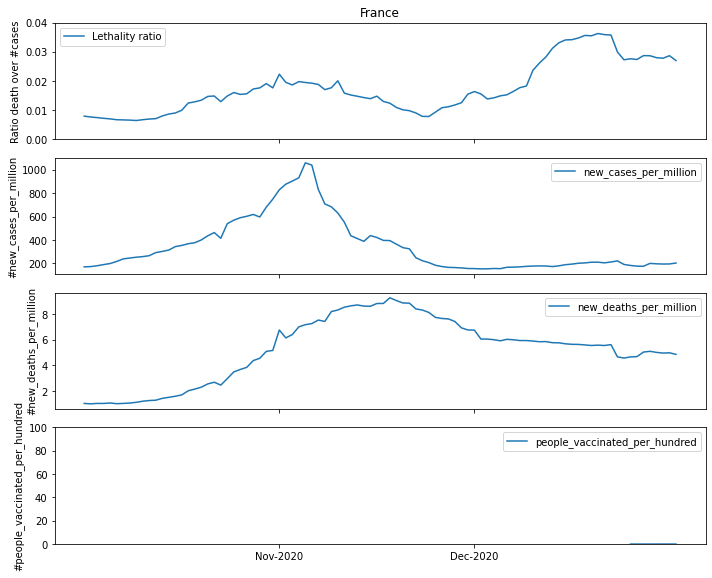

In [3]:
fig = get_lethality_rate(data, 
                         country='France',
                         additional_plots=['new_cases_per_million', 'new_deaths_per_million',
                                           'people_vaccinated_per_hundred'],
                         smoothing_size=7, death_delay=18,
                         start='2020-10-01', end='2020-12-31');
fig.savefig('out/FR-Nov-2020.pdf')

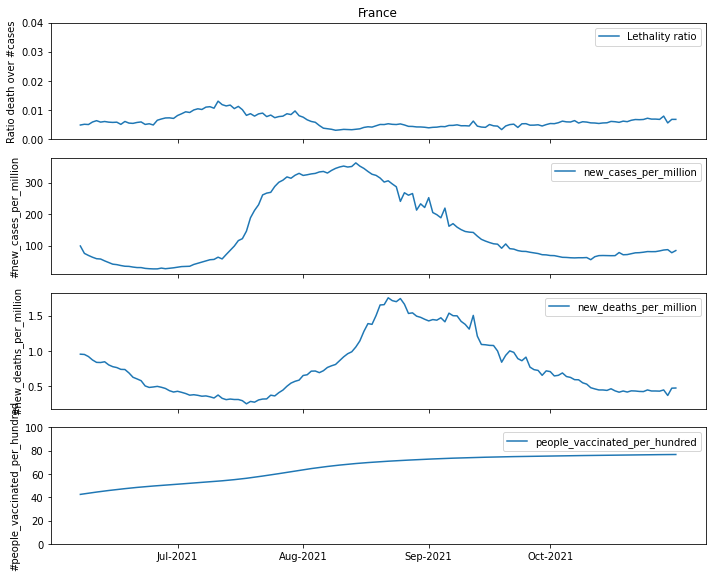

In [4]:
fig = get_lethality_rate(data, 
                         country='France',
                         additional_plots=['new_cases_per_million', 'new_deaths_per_million',
                                           'people_vaccinated_per_hundred'],
                         smoothing_size=7, death_delay=18,
                         start='2021-06-06', end='2021-10-31');
fig.savefig('out/FR-Aug-2021.pdf')

## Other example
In the following plot only the death ratio is plotted

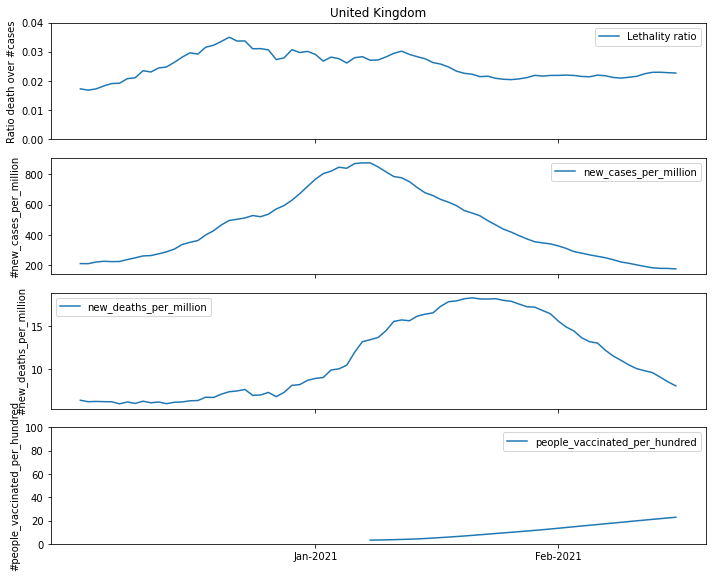

In [5]:
fig = get_lethality_rate(data, 
                         country='United Kingdom',
                         additional_plots=['new_cases_per_million', 'new_deaths_per_million',
                                           'people_vaccinated_per_hundred'],
                         smoothing_size=7, death_delay=18,
                         start='2020-12-01', end='2021-02-15');
fig.savefig('out/UK-Jan-2021.pdf')

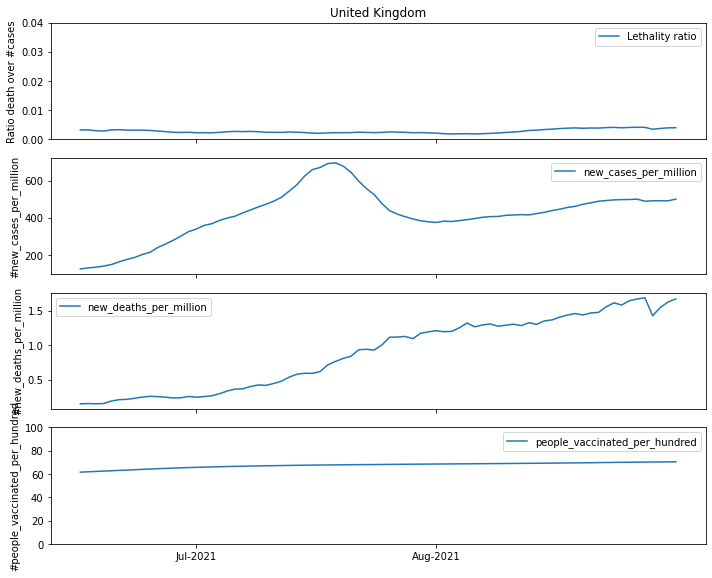

In [6]:
fig = get_lethality_rate(data, 
                         country='United Kingdom',
                         additional_plots=['new_cases_per_million', 'new_deaths_per_million',
                                           'people_vaccinated_per_hundred'],
                         smoothing_size=7, death_delay=18,
                         start='2021-06-15', end='2021-08-31');
fig.savefig('out/UK-Jul-2021.pdf')

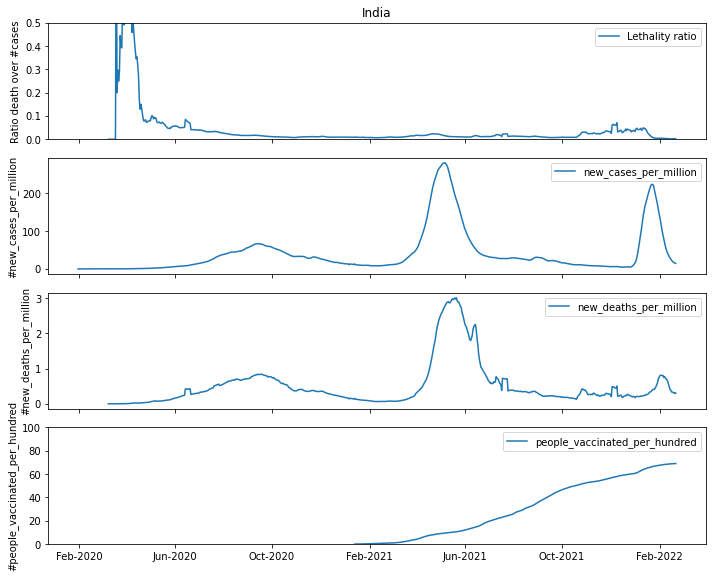

In [7]:
fig = get_lethality_rate(data, 
                         country='India',
                         additional_plots=['new_cases_per_million', 'new_deaths_per_million',
                                           'people_vaccinated_per_hundred'],
                         smoothing_size=7, death_delay=18,
                         start=None, end=None, ylim=(0, .5));
fig.savefig('out/India-whole.pdf')

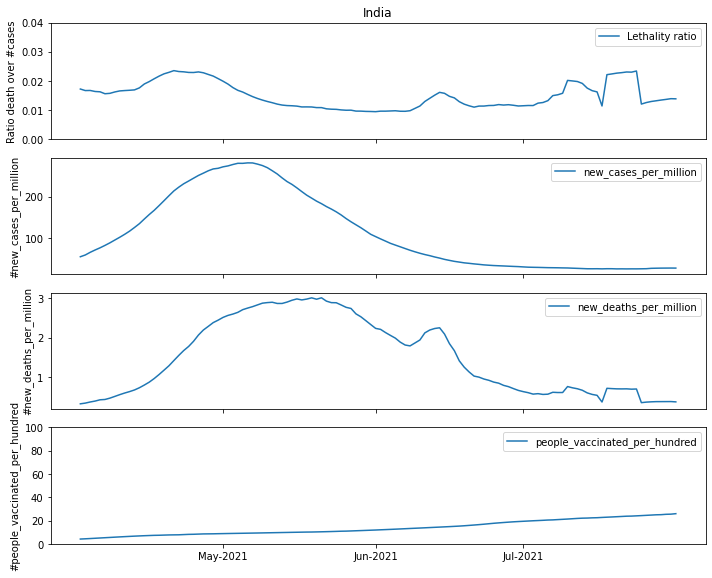

In [8]:
fig = get_lethality_rate(data, 
                         country='India',
                         additional_plots=['new_cases_per_million', 'new_deaths_per_million',
                                           'people_vaccinated_per_hundred'],
                         smoothing_size=7, death_delay=18,
                         start='2021-04-01', end='2021-07-31');
fig.savefig('out/India-Jun-2021.pdf')

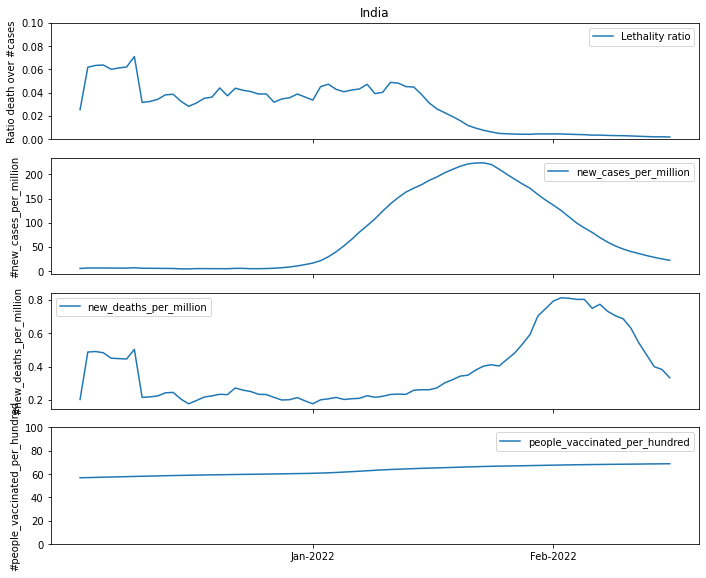

In [9]:
fig = get_lethality_rate(data, 
                         country='India',
                         additional_plots=['new_cases_per_million', 'new_deaths_per_million',
                                           'people_vaccinated_per_hundred'],
                         smoothing_size=7, death_delay=18,
                         start='2021-12-01', end='2022-02-15', ylim=(0, .1));
fig.savefig('out/India-Jun-2021.pdf')